Si è voluto implementare un modo per **ottimizzare i percorsi** dei veicoli di raccolta rifiuti che partono dal centro di raccolta, visualizzandoli su una mappa interattiva.
Il problema trattato per la realizzazione di questo task è il **Capacitated Vehicle Routing Problem (CVRP)**: in questo problema dei veicoli con capacità di trasporto limitata devono raccogliere oggetti in più posizioni, ma senza mai eccedere la capacità dei veicoli.<br>
L’ottimizzazione consiste dunque nell’usare il minor numero possibile di veicoli, fornendo per ognuno di essi un percorso diverso per la raccolta di cestini intelligenti, in base al loro riempimento.

# Install e import dei moduli


Anche qui si è deciso di usare Python con Google Colab, utilizzando i seguenti moduli:

*   ***NumPy***, per creare array, generare valori casuali con distribuzione normale e per calcolare la media di una lista
*   ***Pandas***, per la gestione di dataframe
*   ***Random***, per la generazione di numeri interi casuale
*   ***Requests***, per il download di file online
*   ***Pyrosm***, per la lettura di file con estensione .pbf 
*   ***OSMnx***, per modellare e gestire una grafo di una rete stradale con OpenStreetMap
*   ***NetworkX***, per la gestione del grafo
*   ***Plotly***, per la visualizzazione di nodi e archi stradali su una mappa interattiva
*   ***OR-Tools***, per la risoluzione del CVRP

Vengono installati i moduli assenti in Colab con il comando pip e si fa un restart del runtime con exit() per risolvere problemi di dipendenze con i moduli installati.

In [ ]:
%%capture
!pip install osmnx
!pip install pyrosm
!pip install ortools
exit()

In [ ]:
%%capture
import numpy as np
import random as rd
import pandas as pd
import requests
from pyrosm import OSM, get_data
import osmnx as ox
import networkx as nx
import plotly.graph_objects as go
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

# Inizializza grafo

Per eseguire il task, innanzitutto serve inizializzare il grafo su cui lavorare. Viene scaricato da “[Estratti OpenStreetMap Italia](https://osmit-estratti.wmcloud.org/)” un file con estensione .pbf. Questo sito è un servizio per estrarre dati sull’Italia presenti nel database di OpenStreetMap in più formati, aggiornati con frequenza giornaliera. Nel nostro caso effettuiamo il download dei dati relativi alla città di Bari.<br>
Con un oggetto di classe OSM leggiamo il file .pbf e otteniamo nodi e archi relativi alle strade della città di Bari su cui si può guidare; da questi possiamo creare un grafo con NetworkX. Nel grafo generato gli archi rispettano i sensi di marcia reali.

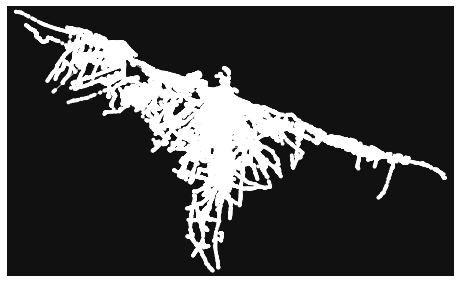

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [ ]:
# Download del file dell'estratto di Bari
download = requests.get('https://osmit-estratti.wmcloud.org/dati/poly/comuni/pbf/072006_Bari_poly.osm.pbf', allow_redirects=True)
open('Bari.osm.pbf', 'wb').write(download.content)

# Inizializza il reader del grafo
osm = OSM("/content/Bari.osm.pbf")

# Ottiene tutte le strade e i nodi su cui si può guidare
nodes, edges = osm.get_network(network_type="driving", nodes=True)

# Crea il grafo NetworkX e lo visualizza
G = osm.to_graph(nodes, edges, graph_type="networkx")
ox.plot_graph(G)

# Percorso Minimo

Per l’ottimizzazione del problema useremo l’algoritmo di Dijkstra del modulo NetworkX per trovare il percorso minimo tra due nodi. È stato scelto l’algoritmo di Dijkstra in quanto il più indicato per lo scopo e il più performante nelle tempistiche.<br>
Vediamo un esempio di ricerca per trovare un percorso minimo date due coordinate nella città di Bari. Definite source e target, troviamo con get_nearest_node il nodo più vicino alle coordinate inserite.

In [ ]:
def plot_path(lat, lon, origin_point, destination_point):
    """
    Data una lista di latitudini e longitudini, e un punto di origine e
    uno di destination, plotta un percorso su una mappa
    
    Parameters
    ----------
    lat, lon: lista di latitudini e longitudini
    origin_point, destination_point: coordinate di origine e destinazione
    
    Returns
    -------
    Mostra solo la mappa
    """

    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = lon,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))
    
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
     
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    lat_center = np.mean(lat)
    lon_center = np.mean(lon)
    
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': lon_center},
                          'zoom': 12.5})
    fig.show()

In [ ]:
# source e target sono tuple di coordinate (x, y)
source = (41.0779317, 16.8607747)
target = (41.1075777, 16.8775971)

# Trova i nodi più vicini a source e target dal grafo
source_node = ox.distance.nearest_nodes(G, source[1], source[0])
target_node = ox.distance.nearest_nodes(G, target[1], target[0])

# printing the closest node id to origin and destination points origin_node, destination_node
route = nx.dijkstra_path(G, source_node, target_node, weight = 'length')

# getting coordinates of the nodes; we will store the longitudes and latitudes in following list 
lon,lat = [],[]
for i in route:
     point = G.nodes[i]
     lon.append(point['x'])
     lat.append(point['y'])

plot_path(lat, lon, source, target)

# Capacited Vehicles Routing Problem (CVRP)

Per risolvere il CVRP sfruttiamo il modulo OR-Tools di Google.<br>
Il problema in input necessita di un numero di nodi da considerare (qui un centro di raccolta e i cestini), il numero massimo di veicoli disponibili e la capacità dei veicoli.<br>
Per la nostra esecuzione abbiamo utilizzato 60 nodi e 6 veicoli con capacità massima di 75. La posizione dei nodi di cestini e centro di raccolta e il riempimento dei cestini sono stati generati in modo casuale. In particolare, la posizione dei nodi viene generata con distribuzione normale attorno a un punto, questo per fare sì che i nodi siano quanto più possibile equamente distribuiti nel centro cittadino. Il  punto centrale è prefissato con coordinate (41.107114,16.874238) per evitare di generare troppi nodi ai confini del grafo da noi considerato.

In [ ]:
def generate_nodes(G, coord, n):
    """
    Dato un grafo, una coppia di coordinate e un intero, genera casualmente un dataframe di nodi 
    del grafo attorno alle coordinate date in input.
    
    Parameters
    ----------
    G: grafo
    coord: coordinate centrali
    n: numero di nodi
    
    Returns
    -------
    df: dataframe con colonne ["latitude","longitude","node"]
    """
    # Crea un dataframe che contiene latitudini e longitudini normalmente distribuiti attorno a un nodo
    df = pd.DataFrame({"latitude":np.random.normal(coord[0], 0.01, n).tolist(), 
                       "longitude":np.random.normal(coord[1], 0.01, n).tolist()})
    
    # Crea la colonna 'node' contenente i nodi più vicini alle coordinate generate
    df["node"] = ox.distance.nearest_nodes(G,df["longitude"],df["latitude"])

    # Assegno a latitude e longitude i valori dei nodi trovati
    df['latitude'] = df.apply(lambda row : G.nodes[row["node"]]["y"], axis = 1)
    df['longitude'] = df.apply(lambda row : G.nodes[row["node"]]["x"], axis = 1)
    return df

def randomize_collection(df):
    """
    Dato un dataframe scambia la prima riga (rappresentante il centro di raccolta) con un'altra riga 
    a caso nel dataframe.
    
    Parameters
    ----------
    df: dataframe di cui scambiare le righe
    
    Returns
    -------
    df: dataframe con le righe scambiate
    """
    i = rd.randint(0,len(df))
    b = df.iloc[i]
    temp = df.iloc[0].copy()
    df.iloc[0] = b
    df.iloc[i] = temp
    return df

def create_data_model(df, num_bins, num_vehicles, vehicle_capacity):
    """
    Dato un dataframe, il numero dei cestini, il numero dei veicoli e la capacità dei veicoli, crea
    il modello dei dati del problema.
    
    Parameters
    ----------
    df: dataframe con colonne ["latitude","longitude","node"]
    num_bins: numero dei cestini
    num_vehicles: numero dei veicoli
    vehicle_capacity: capacità dei veicoli
    
    Returns
    -------
    data: modello di dati del problema
    """
    data = {}
    data["distance_matrix"] = distance_calculator(df,G).tolist()
    data["fill"] = [0] + df.fill.tolist()[1:]
    data["vehicle_capacities"] = [vehicle_capacity]*num_vehicles
    data["num_vehicles"] = num_vehicles
    data["collection"] = 0
    return data

def plot_nodes(lat,lon):
    """
    Data una lista di latitudini e longitudini, plotta i nodi su una mappa
    
    Parameters
    ----------
    lat, long: liste di latitudini e longitudini
 
    Returns
    -------
    Mostra la mappa
    """
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "markers",
        lon = lon,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))
    
    lat_center = np.mean(lat)
    long_center = np.mean(lon)
    
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 12.5})
    fig.show()

def distance_calculator(df,G):
    """
    Dati un dataframe e un grafo, genera la matrice di distanza tra i nodi presenti nel dataframe,
    sfruttando il grafo per ottenere il percorso minimo tra le coppie di nodi, tramite algoritmo di Dijkstra
    
    Parameters
    ----------
    df: dataframe con i nodi di cui calcolare la matrice di distanza
    G: grafo

    Returns
    -------
    distance_result: matrice di distanza tra tutti i nodi
    """
    distance_result = np.zeros((len(df),len(df)))
    for i in range(len(df)):
        for j in range(len(df)):
            distance_result[i][j] = nx.dijkstra_path_length(G, df.node[i], df.node[j], weight="length")
    return distance_result

In [ ]:
# Numero dei cestini (il primo è il centro di raccolta)
num_bins = 60

# Il numero di veicoli massimi disponibili nel centro
vehicle_count = 6

# La capacità dei veicoli
vehicle_capacity = 75

# Imposto latitudine e longitudine centrali
center_coord = (41.107114, 16.874238)

# Genera un dataframe di nodi rappresentanti cestini e centro di raccolta
df = generate_nodes(G, center_coord, num_bins)

# Aggiunge una colonna al dataframe per il riempimento dei cestini
df["fill"] = np.random.randint(0, 10, num_bins).tolist()

# Mostro i nodi
plot_nodes(df.latitude,df.longitude)

Ottenuti i nodi, per ottenere un modello dei dati del problema, serve calcolare la matrice di distanza dei nodi: questa è una matrice quadrata contenente in ogni posizione la distanza tra due nodi. Questo valore come accennato in precedenza sarà ottenuto utilizzando l’algoritmo di Dijkstra.<br>
Creato il modello di dati si passa alla risoluzione del problema, settando il routing model con distanze tra i nodi e riempimenti dei cestini, oltre a creare una dimensione per la capacità dei singoli veicoli.<br>
Se viene trovata una soluzione con gli input inseriti, vengono stampati per ogni veicolo la distanza percorsa e il carico a fine percorso.


In [ ]:
# Rimuovi il commento al rigo seguente per randomizzare il deposito tra i nodi generati (il centro raccolta è il primo nodo del dataframe)
df = randomize_collection(df)

# Istanzio i dati del problema
data = create_data_model(df, num_bins, vehicle_count, vehicle_capacity)

# Create il routing index manager
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['collection'])

# Creo il Routing Model
routing = pywrapcp.RoutingModel(manager)

# Creo e registro un callback di transito
def distance_callback(from_index, to_index):
  """Restituisce la distanza tra due nodi."""
  # Converti dalla variabile di routing Index alla matrice di distanza NodeIndex
  from_node = manager.IndexToNode(from_index)
  to_node = manager.IndexToNode(to_index)
  return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Definisce il costo di ogni arco
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Aggiunge vincolo di capacità
def demand_callback(from_index):
  """Ritorna la pienezza del nodo"""
  from_node = manager.IndexToNode(from_index)
  return data['fill'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # mancanza di capacità nulla
    data['vehicle_capacities'],  # capacità massima dei veicoli
    True,  # inizia cumulo a zero
    'Capacity')

# Imposta l'euristica della soluzione
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.FromSeconds(1)

# RiSolve il problema
solution = routing.SolveWithParameters(search_parameters)

# Se esiste, stampa la soluzione e ottengo una lista di dizionari contenenti percorsi, carico e distanze di ogni veicolo usato
if solution:
    routes = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Vehicle {}:\n'.format(vehicle_id)
        route_distance,route_load = 0,0
        route = {}
        route["path"] = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['fill'][node_index]
            route["path"].append(df.loc[node_index].node)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        route["path"].append(route["path"][0])
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}kg\n'.format(route_load)
        route["distance"] = route_distance
        route["load"] = route_load
        if len(route["path"]) > 2:
            routes.append(route)
        print(plan_output)
    p = []
    for route in routes:
        r = []
        for i in range(len(route["path"])-1):
            r.append(nx.shortest_path(G, route["path"][i], route["path"][i+1], weight = 'length'))
            r[i].pop()
        p.append(r)

Vehicle 0:
Distance of the route: 0m
Load of the route: 0kg

Vehicle 1:
Distance of the route: 0m
Load of the route: 0kg

Vehicle 2:
Distance of the route: 16730m
Load of the route: 71kg

Vehicle 3:
Distance of the route: 11676m
Load of the route: 75kg

Vehicle 4:
Distance of the route: 11894m
Load of the route: 51kg

Vehicle 5:
Distance of the route: 16702m
Load of the route: 68kg



Oltre alla stampa, vengono plottati su una mappa i percorsi ottenuti dalla risoluzione del problema con i nodi dei cestini e il centro di raccolta.

In [ ]:
# Definisco col per generare casulmante un valore tra 0 e 255, utile per la generazione casuale di colori
col = lambda: rd.randint(0,255)

# Plotto i percorsi dei veicoli che partono dal centro di raccolta, mostrando i nodi dei cestini e del centro di raccolta
fig = go.Figure(go.Scattermapbox())

for routes in p:
    lon,lat = [],[]
    for route in routes:
        for i in route:
            point = G.nodes[i]
            lon.append(point['x'])
            lat.append(point['y'])
    fig.add_trace(go.Scattermapbox(
        name = "route " + str(p.index(routes)),
        mode = "lines",
        lon = lon,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4, color = '#%02X%02X%02X' % (col(),col(),col()))))

fig.add_trace(go.Scattermapbox(
    name = "bin",
    mode = "markers",
    lon = df.longitude.tolist()[1:],
    lat = df.latitude.tolist()[1:],
    marker = {'size': 9, 'color':"orange"}))

fig.add_trace(go.Scattermapbox(
    name = "collection",
    mode = "markers",
    lat = [df.latitude[0]],
    lon = [df.longitude[0]],
    marker = {'size': 12, 'color':"black"}))  

lat_center = np.mean(df.latitude.tolist())
lon_center = np.mean(df.longitude.tolist())

fig.update_layout(mapbox_style="stamen-terrain",
                  mapbox_center_lat = 30, mapbox_center_lon=-80)
fig.update_layout(margin={"r":0,"t":20,"l":0,"b":0},
                  mapbox = {
                      'center': {'lat': lat_center,
                      'lon': lon_center},
                      'zoom': 12},
                  showlegend=True)
fig.show()